# Goals

- 단일경구약제 중 TL_81 파일의 것만 학습/분류 (13GB)
- 추후 무슨 종류의 약을 어떤 이유로 학습시키고 싶은지 구체적으로 정하도록

# Done

* 2023/01/12
- import json file and train dataset image names
- Resize train dataset images to 64 x 64
- Process data from json and change to csv (np array?)
> Tags: file_name, dl+name, dl_material

# To-do

* TBD:
- Set Model (Keras)
> input_shape: (64,64,3), softmax(classification)
- Train Data
> Visualize results of Loss/Accuracy w/ matplotlib
- Compare prediction accuracy before/after training

In [55]:
import cv2, json, glob, os, time
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
print(cv2.__version__)
print(sns.__version__)

4.7.0
0.12.1


In [5]:
#json, img 파일 제목 저장

dir_1 = glob.glob('./1.Training/라벨링데이터/단일경구약제 5000종/*')
json_names = []
for temp_dir in dir_1:
    json_names += glob.glob(temp_dir + '/*.*')
print(json_names[:5])

temp_img_dir = glob.glob('./1.Training/images/*')
# temp_img_dir = glob.glob('./1.Training/원천데이터/단일경구약제 5000종/*')
# print(len(temp_img_dir))  #should be 24
img_names = []
for temp in temp_img_dir:
    img_names += glob.glob(temp + '/*.*')
print(img_names[:5])

['./1.Training/라벨링데이터/단일경구약제 5000종\\K-038884_json\\K-038884_0_0_0_0_75_000_200.json', './1.Training/라벨링데이터/단일경구약제 5000종\\K-038884_json\\K-038884_0_0_0_0_75_020_200.json', './1.Training/라벨링데이터/단일경구약제 5000종\\K-038884_json\\K-038884_0_0_0_0_75_040_200.json', './1.Training/라벨링데이터/단일경구약제 5000종\\K-038884_json\\K-038884_0_0_0_0_75_060_200.json', './1.Training/라벨링데이터/단일경구약제 5000종\\K-038884_json\\K-038884_0_0_0_0_75_080_200.json']
['./1.Training/images\\K-038884\\K-038884_0_0_0_0_75_000_200.png', './1.Training/images\\K-038884\\K-038884_0_0_0_0_75_020_200.png', './1.Training/images\\K-038884\\K-038884_0_0_0_0_75_040_200.png', './1.Training/images\\K-038884\\K-038884_0_0_0_0_75_060_200.png', './1.Training/images\\K-038884\\K-038884_0_0_0_0_75_080_200.png']


In [14]:
#IMG_RESIZE
#조장 김지수님 코드 기반

i = 0
# os.mkdir('Data/1.Training/images/' + 'hi')
for idx, img_data in enumerate(json_names):
    img_data = img_data.replace('\\', '/', 10)
    # print(img_data)
    with open(img_data, 'r', encoding='UTF=8') as j:
        js = json.load(j)
        file_name = js['images'][0]['file_name']
        file_dir = './1.Training/images/' + file_name[:8]
        # print(file_dir)
        if not os.path.isdir(file_dir):
            print('Saving directory:',file_dir) #추가
            os.mkdir(file_dir)

        file_dir = file_dir + '/' + file_name

        if not os.path.isfile(file_dir):
            # print(file_dir)
            x, y, w, h = js['annotations'][0]['bbox']

            cx = x + w // 2
            cy = y + h // 2
            w_h, h_h = max(w, h), max(w, h)  # 깨끗한 data 를 얻기 위해 크롭영역을 정방형으로 해준다. 기준은 둘 중 큰 값
            x = cx - (w_h // 2)
            y = cy - (h_h // 2)

            # print(x, y, w, h)
            img_names[idx] = img_names[idx].replace('\\', '/', 10)
            # print(img_names[idx])
            img = cv2.imread(img_names[idx], cv2.IMREAD_COLOR)
            
            cropped_img = img[y:y + h_h, x:x + w_h]
            cropped_img = cv2.resize(cropped_img, (64, 64))
            if idx % 100 == 0:
                print('진행상황: {} / {}'.format(idx, len(img_names)))
            # cv2.imwrite(file_dir, cropped_img)
        else:
            print(f'Data named {file_dir} already processed.')
            continue

Data named ./1.Training/images/K-038884/K-038884_0_0_0_0_75_000_200.png already processed.
Data named ./1.Training/images/K-038884/K-038884_0_0_0_0_75_020_200.png already processed.
Data named ./1.Training/images/K-038884/K-038884_0_0_0_0_75_040_200.png already processed.
Data named ./1.Training/images/K-038884/K-038884_0_0_0_0_75_060_200.png already processed.
Data named ./1.Training/images/K-038884/K-038884_0_0_0_0_75_080_200.png already processed.
Data named ./1.Training/images/K-038884/K-038884_0_0_0_0_75_100_200.png already processed.
Data named ./1.Training/images/K-038884/K-038884_0_0_0_0_75_120_200.png already processed.
Data named ./1.Training/images/K-038884/K-038884_0_0_0_0_75_140_200.png already processed.
Data named ./1.Training/images/K-038884/K-038884_0_0_0_0_75_160_200.png already processed.
Data named ./1.Training/images/K-038884/K-038884_0_0_0_0_75_180_200.png already processed.
Data named ./1.Training/images/K-038884/K-038884_0_0_0_0_75_200_200.png already processed.

In [86]:
#JSON 내용 불러오기
'''
dir_1 = glob.glob('./1.Training/라벨링데이터/단일경구약제 5000종/*')
json_names = []
for temp in dir_1:
    json_names += glob.glob(temp + '/*.*')
# print(json_names[:5])
'''

#태그별로 리스트를 만들어서 저장
num_lst=[]
img_lst=[]
name_lst=[]
type_lst=[]
img_fp=[]

def json_var(list, tag):
    list.append(js['images'][0][tag])

for idx, img_data in enumerate(json_names):
    img_data = img_data.replace('\\', '/', 10)
    # print(img_data)   #debug
    with open(img_data, 'r', encoding='UTF=8') as j:
        js = json.load(j)
        file_name = js['images'][0]['file_name']
        file_dir = './1.Training/images/' + file_name[:8]

        json_var(img_lst, 'file_name')
        json_var(name_lst, 'dl_name')
        json_var(type_lst, 'dl_material')
        num_lst.append(file_name[:8])
        img_fp.append(file_dir)

print(num_lst[:5], img_lst[:5], name_lst[:5], type_lst[:5], img_fp[:5], sep='\n')

['K-038884', 'K-038884', 'K-038884', 'K-038884', 'K-038884']
['K-038884_0_0_0_0_75_000_200.png', 'K-038884_0_0_0_0_75_020_200.png', 'K-038884_0_0_0_0_75_040_200.png', 'K-038884_0_0_0_0_75_060_200.png', 'K-038884_0_0_0_0_75_080_200.png']
['에피나레정', '에피나레정', '에피나레정', '에피나레정', '에피나레정']
['에피나스틴염산염', '에피나스틴염산염', '에피나스틴염산염', '에피나스틴염산염', '에피나스틴염산염']
['./1.Training/images/K-038884', './1.Training/images/K-038884', './1.Training/images/K-038884', './1.Training/images/K-038884', './1.Training/images/K-038884']


In [90]:
#Save PD dataframe to CSV

df_info={'num_id': num_lst, 'file_name': img_lst, 'img_dir': img_fp, 'pill_name': name_lst, 'pill_type': type_lst}
df_info=pd.DataFrame(df_info)
df_info.to_csv("./2.Sample/pill_df.csv",index=False)
df=pd.read_csv("./2.Sample/pill_df.csv")
df.sample(10).head

<bound method NDFrame.head of         num_id                        file_name                       img_dir  \
3712  K-038967  K-038967_0_2_0_2_90_080_200.png  ./1.Training/images/K-038967   
3581  K-038967  K-038967_0_2_0_0_70_340_200.png  ./1.Training/images/K-038967   
6574  K-039136  K-039136_0_1_1_2_90_080_200.png  ./1.Training/images/K-039136   
4491  K-039036  K-039036_0_1_0_1_70_180_200.png  ./1.Training/images/K-039036   
4312  K-039021  K-039021_0_2_1_0_90_200_200.png  ./1.Training/images/K-039021   
6128  K-039136  K-039136_0_0_1_2_75_160_200.png  ./1.Training/images/K-039136   
9035  K-039147  K-039147_0_1_1_0_90_340_200.png  ./1.Training/images/K-039147   
3532  K-038962  K-038962_0_2_1_2_75_080_200.png  ./1.Training/images/K-038962   
5236  K-039104  K-039104_0_0_1_1_75_320_200.png  ./1.Training/images/K-039104   
808   K-038910  K-038910_0_0_0_0_90_320_200.png  ./1.Training/images/K-038910   

                     pill_name  \
3712            엘도스인캡슐(에르도스테인)   
3581      

In [88]:
cnt_by_id=df['num_id'].value_counts()
cnt_by_id

K-039147    1296
K-039146    1296
K-039136    1296
K-038954     324
K-039047     324
K-039036     324
K-039021     324
K-038967     324
K-038958     324
K-038962     324
K-038929     324
K-038927     324
K-038910     324
K-038896     324
K-038959     216
K-038890     216
K-038970     216
K-038914     216
K-038913     216
K-038912     216
K-039104     216
K-039108     216
K-039123     216
K-038884     216
Name: num_id, dtype: int64

<AxesSubplot: >

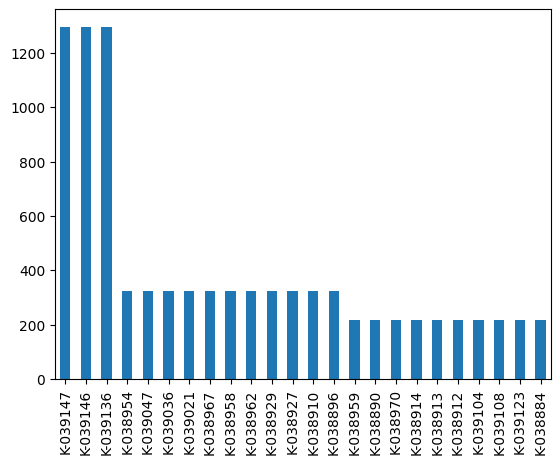

In [89]:
#종류별 시각화
cnt_by_id.plot.bar()